<a href="https://colab.research.google.com/github/MINDS-edu/The-5th-POSTECH-Youth-Mathematical-Artificial-Intelligence-Academy/blob/master/PYMAIA5_day3_CNN_%EC%9D%B4%EB%A1%A0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 수업 순서: CNN 수기 계산

3주차 이론 수업에서는 CNN(합성곱 신경망)의 Convolution 및 Max Pooling 연산을 수강생들이 직접 수행하여, equivariance(동변성/등변성) 및 invariance(불변성)의 특성을 보다 더 직접적으로 체험하도록 합니다.

※ 본 파일은 수업 진행 시 직접적으로 실행될 용도가 아니며, 수업 전 조교들이 예제를 준비하는 과정에 도움을 주기 위해 제작된 파일입니다.

##### 환경설정

###### 라이브러리

In [ ]:
import numpy as np

# import만으로 한글 깨짐 방지
!pip install koreanize_matplotlib

import koreanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

###### 합성곱 신경망 관련 함수

In [2]:
def convolution(arr, kernel, zero_padding=True):
    """2D 컨볼루션 연산을 수행하는 함수"""
    arr_h, arr_w = arr.shape
    kernel_h, kernel_w = kernel.shape

    # 제로 패딩 처리 (상, 하, 좌, 우 1칸)
    if zero_padding:
        # np.pad는 (상, 하), (좌, 우) 형태로 패딩을 지정
        padded_arr = np.pad(arr, ((1, 1), (1, 1)), "constant", constant_values=0)
    else:
        padded_arr = arr

    # 패딩된 배열의 크기
    padded_h, padded_w = padded_arr.shape

    # 출력 배열의 크기 (일반적으로 'same' 패딩 시 입력과 동일한 크기)
    output_h = padded_h - kernel_h + 1
    output_w = padded_w - kernel_w + 1

    # 결과 배열 초기화
    output = np.zeros((output_h, output_w))

    # 컨볼루션 연산 수행
    for i in range(output_h):
        for j in range(output_w):
            # 커널을 적용할 영역 추출
            region = padded_arr[i:i + kernel_h, j:j + kernel_w]
            # 원소별 곱셈 후 합산 (컨볼루션)
            output[i, j] = np.sum(region * kernel)

    return output

def max_pooling(arr):
    """2D 맥스 풀링 연산을 수행하는 함수 (2x2 필터, 스트라이드 2, 필요 시 제로 패딩)"""
    arr_h, arr_w = arr.shape

    # 풀링 필터 크기 및 스트라이드
    pool_h, pool_w = 2, 2
    stride_h, stride_w = 2, 2

    # 홀수 길이인 경우 제로 패딩 추가
    pad_h = 0
    if arr_h % stride_h != 0:
        pad_h = stride_h - (arr_h % stride_h) # 스트라이드의 배수가 되도록 패딩할 높이 계산

    pad_w = 0
    if arr_w % stride_w != 0:
        pad_w = stride_w - (arr_w % stride_w) # 스트라이드의 배수가 되도록 패딩할 너비 계산

    # np.pad는 (상, 하), (좌, 우) 형태로 패딩을 지정
    # 여기서는 주로 오른쪽과 아래쪽에만 패딩을 추가하므로 ((0, pad_h), (0, pad_w)) 사용
    padded_arr = np.pad(arr, ((0, pad_h), (0, pad_w)), "constant", constant_values=0)

    # 패딩된 배열의 크기 업데이트
    padded_h, padded_w = padded_arr.shape

    # 출력 배열의 크기 계산 (이제 패딩으로 인해 항상 정수로 나누어 떨어짐)
    output_h = padded_h // stride_h
    output_w = padded_w // stride_w

    output = np.zeros((output_h, output_w))

    # 맥스 풀링 연산 수행
    for i in range(output_h):
        for j in range(output_w):
            # 풀링할 영역 추출
            region = padded_arr[i * stride_h : i * stride_h + pool_h,
                                j * stride_w : j * stride_w + pool_w]
            # 영역 내 최대값 선택
            output[i, j] = np.max(region)

    return output

def concat_and_flatten(list_of_arr):
    """여러 배열을 이어 붙여 평탄화하는 함수"""
    flattened_arrays = []
    for arr in list_of_arr:
        # 각 배열을 1차원으로 평탄화
        if arr is not None:
             flattened_arrays.append(arr.flatten())

    # 평탄화된 모든 배열을 하나로 이어 붙임
    if not flattened_arrays:
        return np.array([]) # 연결할 유효한 배열이 없을 경우 빈 배열을 반환

    return np.concatenate(flattened_arrays)

def dot_product(arr0, arr1):
    """두 배열의 내적(dot product)을 계산하는 함수"""
    # NumPy의 dot 함수를 사용하여 내적 계산
    return np.dot(arr0, arr1)

###### 이쁜 출력 함수

In [3]:
def array_string_display(nparray):
    """배열을 보기 좋게 출력하는 함수"""
    print(np.array_str(nparray, precision=2, suppress_small=True)+'\n')

In [ ]:
class ArrayDisplayer:
    """배열을 이쁜 히트맵으로 시각화하는 클래스

    -1 부터 3 까지의 숫자에 이쁜 색깔들을 부여합니다.

    OKLCH 색공간을 사용하여 사람의 눈에 자연스러운 그라데이션을 생성합니다.
    (참고: 코딩애플 유튜브 - https://youtu.be/GHe5EGvXFgM)

    본 클래스는 제미나이에 의해 작성된 코드입니다. 깃허브에 커밋한 조교가 바닥에 주저앉아 우는 광경을
    보고 싶지 않다면, 해당 조교에게 코드 해설을 부탁하지 않길 바랍니다. 알아서 사용하시면 됩니다.
    """

    def __init__(
        self,
        my_black="#000000",
        my_white="#FFFFFF",
        my_red="#FF0000",
        my_blue="#0000FF",
        my_yellow="#FFFF00"
    ):

        # 1. 색상 설정 저장
        self.hex_anchors = {
            "black": my_black,
            "white": my_white,
            "red": my_red,
            "blue": my_blue,
            "yellow": my_yellow
        }

        # 2. 컬러맵 생성 (초기화 시 한 번만 수행하여 성능 최적화)
        self.cmap = self._create_custom_cmap()

    def run(self, nparray, title: str = "Array Visualization"):
        """배열을 입력받아 컬러바/틱 없이 깔끔한 정사각형 그리드로 시각화

        Args:
            nparray (np.ndarray): 시각화할 배열 (1D 또는 2D)
            title (str): 차트 제목
        """
        # 1. 입력 데이터 전처리 (1차원이면 2차원 행 벡터로 변환)
        if nparray.ndim == 1:
            nparray = nparray.reshape(1, -1)

        rows, cols = nparray.shape

        # 2. [Rule-based Figsize] 칸 개수에 맞춰 이미지 크기 계산
        # 한 칸당 약 0.8인치 할당 + 여백 확보
        # 1x16 같은 긴 배열도 찌그러지지 않고 정사각형 비율 유지
        cell_size = 0.8
        fig_width = max(cols * cell_size, 4.0) # 너무 작아지지 않게 최소 폭 4인치
        fig_height = max(rows * cell_size, 2.0) + 0.5 # 제목 공간 +0.5인치

        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

        # 3. 히트맵 그리기
        # aspect="equal": 셀을 강제로 정사각형으로 고정
        ax.imshow(nparray, cmap=self.cmap, vmin=-1, vmax=3, aspect="equal")

        # 4. 숫자 텍스트 표시
        for i in range(rows):
            for j in range(cols):
                val = nparray[i, j]
                # 글자색 자동 반전 (가독성 확보)
                # 회색 구간(-0.5 ~ 0.5)과 노랑 구간(2.5 이상)은 검은 글씨, 나머지는 흰 글씨
                text_color = "black" if (-0.5 < val < 0.5) or (val > 2.5) else "white"

                # 값이 정수라면 소수점 제거, 실수라면 소수점 2자리
                if isinstance(val, (int, np.integer)) or val.is_integer():
                    disp_val = f"{int(val)}"
                else:
                    disp_val = f"{val:.2f}"

                ax.text(j, i, disp_val, ha="center", va="center", color=text_color,
                        fontsize=10, fontweight="bold")

        # 5. 데코레이션 제거 (틱, 테두리 없애기)
        ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
        ax.axis("off") # 축, 눈금, 테두리 싹 다 제거

        plt.tight_layout()
        plt.show()

    # ==========================================================================
    # [내부 로직] OKLCH 수학 연산 및 보간 (외부에서 호출할 필요 없음)
    # ==========================================================================

    def _create_custom_cmap(self):
        """구간별 다른 전략을 사용하여 전체 컬러맵을 생성"""

        # 1. Hex -> sRGB -> OKLCH 변환
        colors_oklch = {}
        for key, hex_code in self.hex_anchors.items():
            srgb = mcolors.to_rgb(hex_code)
            colors_oklch[key] = self._srgb_to_oklch(np.array(srgb))

        interpolated_colors = []
        steps = 64 # 구간별 부드러움 정도

        # --- 구간 1: -1(Black) -> 0(White) ---
        # 전략: 무채색 구간이므로 단순히 밝기(L)만 증가시킴
        seg1 = self._interpolate_segment(colors_oklch["black"], colors_oklch["white"], steps, strategy="linear")
        interpolated_colors.extend(seg1)

        # --- 구간 2: 0(White) -> 1(Red) ---
        # 전략: White는 색상이 없으므로, Red의 Hue를 강제로 주입하여 핑크~레드로 변하게 함
        white_mod = colors_oklch["white"].copy()
        white_mod[2] = colors_oklch["red"][2] # Hue 복사
        seg2 = self._interpolate_segment(white_mod, colors_oklch["red"], steps, strategy="linear")
        interpolated_colors.extend(seg2[1:]) # 첫 점 중복 제거

        # --- 구간 3: 1(Red) -> 2(Blue) ---
        # 전략: 빨강->파랑 최단 경로 (보라색 통과)
        seg3 = self._interpolate_segment(colors_oklch["red"], colors_oklch["blue"], steps, strategy="shortest_path")
        interpolated_colors.extend(seg3[1:])

        # --- 구간 4: 2(Blue) -> 3(Yellow) ---
        # 전략: 파랑->노랑 최단 경로 (초록색 통과)
        seg4 = self._interpolate_segment(colors_oklch["blue"], colors_oklch["yellow"], steps, strategy="shortest_path")
        interpolated_colors.extend(seg4[1:])

        return mcolors.LinearSegmentedColormap.from_list("CustomOKLCH", interpolated_colors)

    def _interpolate_segment(self, start_oklch, end_oklch, steps, strategy="linear"):
        """두 OKLCH 색상 사이를 정의된 전략으로 보간"""
        t = np.linspace(0, 1, steps)

        # L(명도), C(채도)는 항상 선형 보간
        L = start_oklch[0] * (1 - t) + end_oklch[0] * t
        C = start_oklch[1] * (1 - t) + end_oklch[1] * t

        # H(색상) 보간 전략
        if strategy == "shortest_path":
            # 각도 최단 경로 계산
            delta = end_oklch[2] - start_oklch[2]
            if delta > 180: delta -= 360
            elif delta < -180: delta += 360
            H = start_oklch[2] + delta * t
            H = H % 360 # 0~360 정규화
        else:
            # 단순 선형 (색상이 중요하지 않거나, 이미 맞춰진 경우)
            H = start_oklch[2] * (1 - t) + end_oklch[2] * t

        # 다시 RGB로 변환하여 반환
        oklch_segment = np.stack([L, C, H], axis=-1)
        return [self._oklch_to_srgb(c) for c in oklch_segment]

    # --- 수학적 변환 함수 (라이브러리 의존성 제거) ---

    def _srgb_to_oklch(self, srgb):
        """sRGB -> Linear RGB -> XYZ -> LMS -> OKLab -> OKLCH"""
        # 1. Inverse Gamma Correction (sRGB -> Linear RGB)
        # (간단한 근사식 대신 정확한 sRGB 공식 사용 시 코드가 길어지므로, 시각화용으로는 2.2 감마 근사로도 충분하지만 정확성을 위해 행렬 사용)
        # 여기서는 colour-science 없이 구현하기 위해 간단한 근사(power 2.2)보다는 조금 더 정교한 변환을 약식으로 수행
        # 편의상 입력 sRGB가 이미 gamma encoding 되어 있다고 가정하고 numpy 연산

        # sRGB to XYZ (D65) matrix
        M_srgb_xyz = np.array([[0.4124, 0.3576, 0.1805],
                               [0.2126, 0.7152, 0.0722],
                               [0.0193, 0.1192, 0.9505]])

        # Gamma expansion (approximate for display code simplicity)
        lin_rgb = np.where(srgb > 0.04045, ((srgb + 0.055) / 1.055) ** 2.4, srgb / 12.92)
        xyz = np.dot(M_srgb_xyz, lin_rgb)

        # XYZ to LMS (Oklab M1)
        M1 = np.array([[0.8189330101, 0.3618667424, -0.1288597137],
                       [0.0329845436, 0.9293118715, 0.0361456387],
                       [0.0482003018, 0.2643662691, 0.6338517070]])
        lms = np.dot(M1, xyz)
        lms_prime = np.cbrt(np.maximum(lms, 0))

        # LMS to OKLab (M2)
        M2 = np.array([[0.2104542553, 0.7936177850, -0.0040720468],
                       [1.9779984951, -2.4285922050, 0.4505937099],
                       [0.0259040371, 0.7827717662, -0.8086757660]])
        lab = np.dot(M2, lms_prime)

        # OKLab to OKLCH
        L, a, b = lab
        C = np.sqrt(a**2 + b**2)
        H = np.degrees(np.arctan2(b, a)) % 360
        return np.array([L, C, H])

    def _oklch_to_srgb(self, oklch):
        """OKLCH -> ... -> sRGB"""
        L, C, H = oklch
        h_rad = np.radians(H)

        # OKLCH to OKLab
        a = C * np.cos(h_rad)
        b = C * np.sin(h_rad)
        lab = np.array([L, a, b])

        # OKLab to LMS (Inverse M2)
        InvM2 = np.array([[1, 0.3963377774, 0.2158037573],
                          [1, -0.1055613458, -0.0638541728],
                          [1, -0.0894841775, -1.2914855480]])
        lms_prime = np.dot(lab, InvM2.T) # Note: transposed for vector dot product
        lms = lms_prime ** 3

        # LMS to XYZ (Inverse M1)
        InvM1 = np.array([[1.2270138511, -0.5577999807, 0.2812561490],
                          [-0.0405801784, 1.1122568696, -0.0716766787],
                          [-0.0763812845, -0.4214819784, 1.5861632204]])
        xyz = np.dot(lms, InvM1.T)

        # XYZ to Linear RGB
        # Inverse sRGB matrix
        InvM_srgb = np.array([[3.2406, -1.5372, -0.4986],
                              [-0.9689, 1.8758, 0.0415],
                              [0.0557, -0.2040, 1.0570]])
        lin_rgb = np.dot(xyz, InvM_srgb.T)

        # Gamma compression (Linear RGB -> sRGB)
        srgb = np.where(lin_rgb > 0.0031308, 1.055 * (lin_rgb ** (1/2.4)) - 0.055, 12.92 * lin_rgb)

        return np.clip(srgb, 0, 1)


displayer = ArrayDisplayer()

## 🧾 예제 준비
- 조교들은 아래 코드를 예제 준비에 활용하실 수 있습니다.

### 🖼️ 예제 이미지

In [5]:
A = np.array([
  [0, 0, 0, 0, 0, 0],
  [0, 1, 1, 1, 0, 0],
  [0, 1, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]
])

B = np.array([
  # [0, 0, 0, 0, 0, 0],
  # [0, 0, 0, 0, 0, 0],
  # [0, 0, 1, 1, 1, 0],
  # [0, 0, 1, 0, 0, 0],
  # [0, 0, 0, 0, 0, 0],
  # [0, 0, 0, 0, 0, 0]
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0],
  [0, 0, 1, 1, 1, 0],
  [0, 0, 1, 0, 0, 0],
  [0, 0, 0, 0, 0, 0]
])

### 👁️ 예제 커널

In [6]:
k11 = np.array([
  [0, 0, 0],
  [0.25, 0.5, 0.25],
  [0, 0, 0]
])

k12 = np.array([
  [0, 0, 0],
  [0, 0.5, 0],
  [0, 0.5, 0]
])

k21 = np.array([
  [0, 0, 0],
  [0, 0, 2],
  [0, 0, 0]
])

k22 = np.array([
  [0, 0, 0],
  [0, 0, 0],
  [0, 2, 0]
])

k3 = np.array(
  # [0.45, 0.17, -0.53, 1.09, 0.6, 1/3, 1/29, np.pi, -0.3, 1/37, np.e, -0.73, -0.2, -0.6, 0.89, 0.41]
  [0.45, -0.83, -0.4, -0.89, 0.2, 1/3, 1/13, np.pi, 0.1, 17/23, -0.6, -31/23, 0.3, -0.1, np.e, 0.53]
)

### ⚙️ 예제 테스트

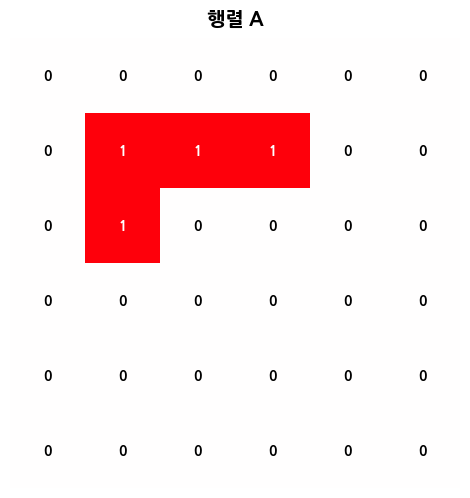

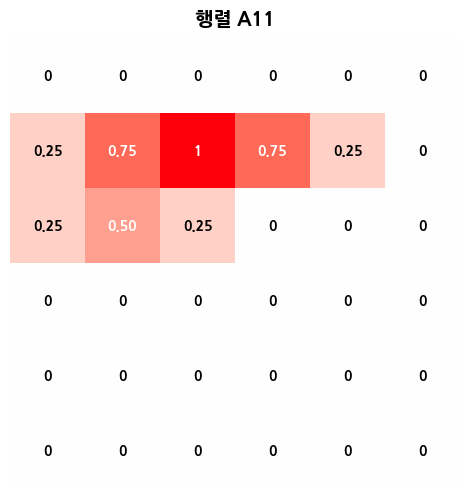

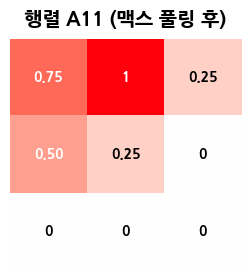

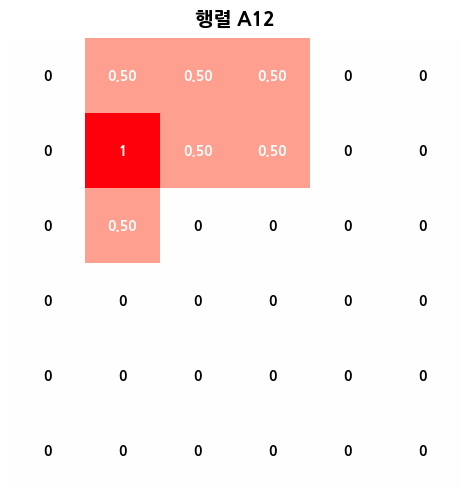

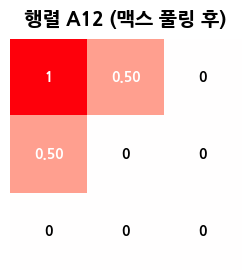

--------------------



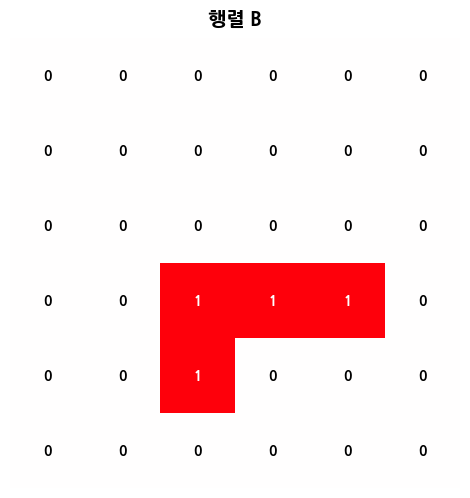

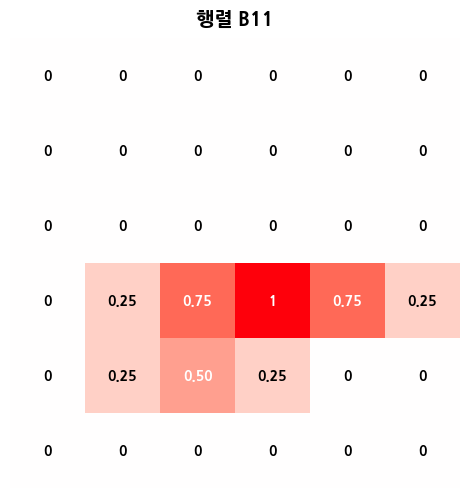

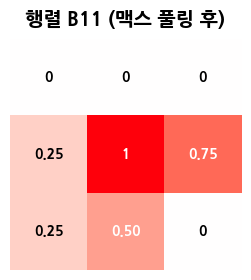

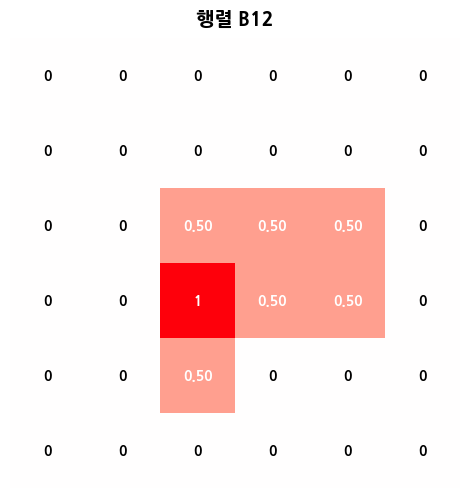

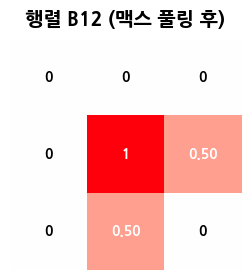

In [7]:
displayer.run(A, "행렬 A")

A11 = convolution(A, k11)
displayer.run(A11, "행렬 A11")
A11 = max_pooling(A11)
displayer.run(A11, "행렬 A11 (맥스 풀링 후)")

A12 = convolution(A, k12)
displayer.run(A12, "행렬 A12")
A12 = max_pooling(A12)
displayer.run(A12, "행렬 A12 (맥스 풀링 후)")

print("--------------------\n")

displayer.run(B, "행렬 B")

B11 = convolution(B, k11)
displayer.run(B11, "행렬 B11")
B11 = max_pooling(B11)
displayer.run(B11, "행렬 B11 (맥스 풀링 후)")

B12 = convolution(B, k12)
displayer.run(B12, "행렬 B12")
B12 = max_pooling(B12)
displayer.run(B12, "행렬 B12 (맥스 풀링 후)")

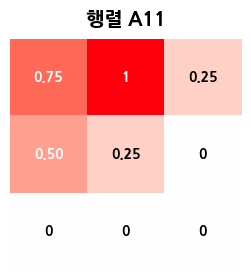

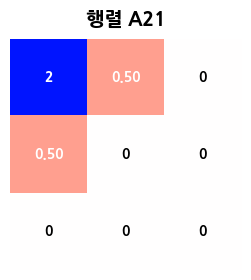

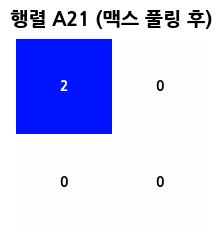

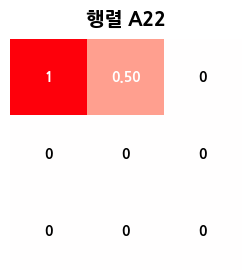

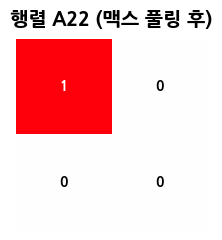

--------------------



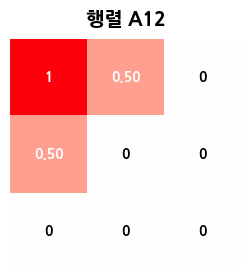

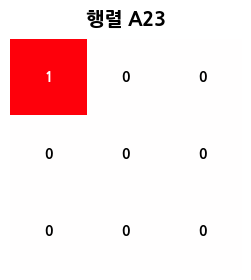

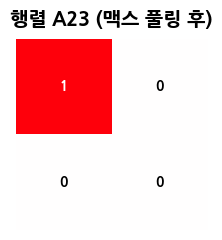

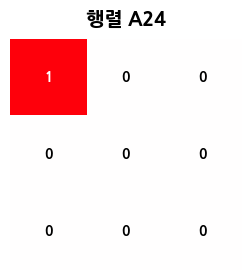

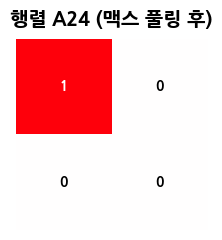

--------------------



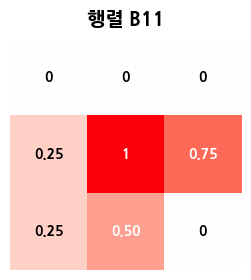

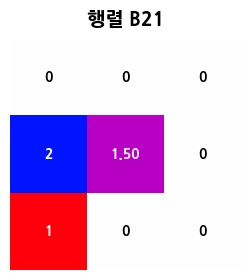

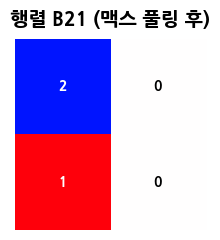

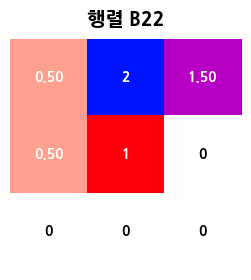

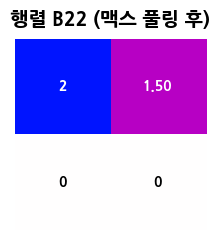

--------------------



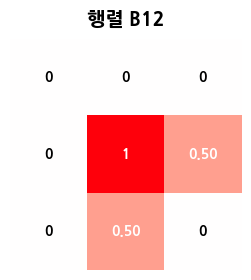

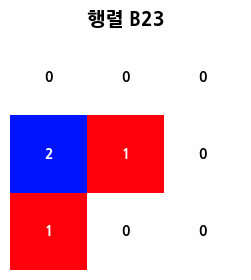

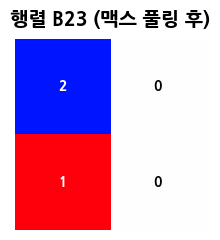

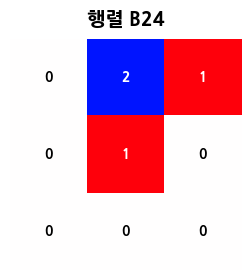

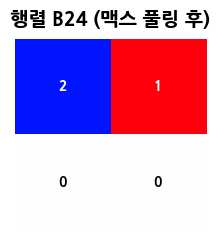

In [8]:
displayer.run(A11, "행렬 A11")

A21 = convolution(A11, k21)
displayer.run(A21, "행렬 A21")
A21 = max_pooling(A21)
displayer.run(A21, "행렬 A21 (맥스 풀링 후)")

A22 = convolution(A11, k22)
displayer.run(A22, "행렬 A22")
A22 = max_pooling(A22)
displayer.run(A22, "행렬 A22 (맥스 풀링 후)")

print("--------------------\n")

displayer.run(A12, "행렬 A12")

A23 = convolution(A12, k21)
displayer.run(A23, "행렬 A23")
A23 = max_pooling(A23)
displayer.run(A23, "행렬 A23 (맥스 풀링 후)")

A24 = convolution(A12, k22)
displayer.run(A24, "행렬 A24")
A24 = max_pooling(A24)
displayer.run(A24, "행렬 A24 (맥스 풀링 후)")

print("--------------------\n")

displayer.run(B11, "행렬 B11")

B21 = convolution(B11, k21)
displayer.run(B21, "행렬 B21")
B21 = max_pooling(B21)
displayer.run(B21, "행렬 B21 (맥스 풀링 후)")

B22 = convolution(B11, k22)
displayer.run(B22, "행렬 B22")
B22 = max_pooling(B22)
displayer.run(B22, "행렬 B22 (맥스 풀링 후)")

print("--------------------\n")

displayer.run(B12, "행렬 B12")

B23 = convolution(B12, k21)
displayer.run(B23, "행렬 B23")
B23 = max_pooling(B23)
displayer.run(B23, "행렬 B23 (맥스 풀링 후)")

B24 = convolution(B12, k22)
displayer.run(B24, "행렬 B24")
B24 = max_pooling(B24)
displayer.run(B24, "행렬 B24 (맥스 풀링 후)")

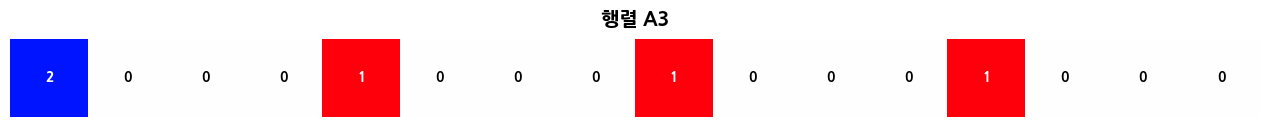

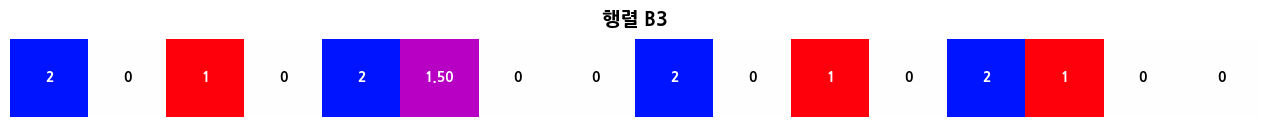

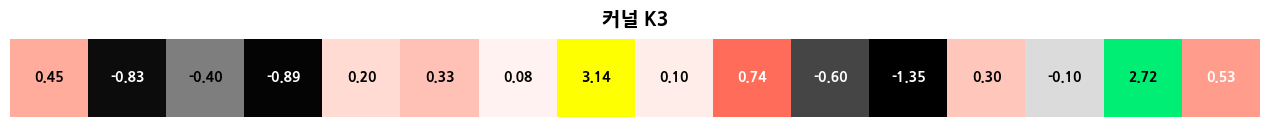

In [9]:
A3 = concat_and_flatten([A21, A22, A23, A24])
B3 = concat_and_flatten([B21, B22, B23, B24])

displayer.run(A3, "행렬 A3")
displayer.run(B3, "행렬 B3")
displayer.run(k3, "커널 K3")

In [10]:
a4 = dot_product(A3, k3)
print(a4)

b4 = dot_product(B3, k3)
print(b4)

1.5
1.5
